In [64]:
import matplotlib.pyplot as plt
import QuantLib as ql 

from abc import ABC, abstractmethod
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

In [65]:
class EuropeanOptionInstrument(ABC):
    def __init__(self, strike_price, maturity, option_type):
        self.strike_price = tf.Variable(strike_price, dtype=tf.float32)
        self.maturity = tf.Variable(maturity, dtype=tf.float32)
        self.option_type = option_type  # "Call" or "Put"

    @abstractmethod
    def calculate_payoff(self, market_price):
        pass

    @abstractmethod
    def calculate_intrinsic_value(self, market_price):
        pass

    @abstractmethod
    def calculate_time_value(self, market_price):
        pass

    def display_information(self):
        print(f"Strike Price: {self.strike_price}")
        print(f"Maturity: {self.maturity} years")
        print(f"Option Type: {self.option_type}")

    @property
    @abstractmethod
    def is_exercisable(self):
        pass

class EuropeanCallOption(EuropeanOptionInstrument):
    def calculate_payoff(self, market_price):
        return max(market_price - self.strike_price, 0)

    def calculate_intrinsic_value(self, market_price):
        return max(market_price - self.strike_price, 0)

    def calculate_time_value(self, market_price):
        intrinsic_value = self.calculate_intrinsic_value(market_price)
        return max(0, market_price - intrinsic_value)

    @property
    def is_exercisable(self):
        return True if self.maturity > 0 else False
    
class BlackScholesPricing:
    
    def __init__(self, option: EuropeanOptionInstrument, spot_price, risk_free_rate, volatility):
        self.option = option
        self.spot_price = tf.Variable(spot_price, dtype=tf.float32)
        self.risk_free_rate = tf.Variable(risk_free_rate, dtype=tf.float32)
        self.volatility = tf.Variable(volatility, dtype=tf.float32)

    def calculate_option_price(self):
        d1 = (tf.math.log(self.spot_price / self.option.strike_price) + (
            self.risk_free_rate + (self.volatility ** 2) / 2) * self.option.maturity) / (self.volatility * tf.sqrt(self.option.maturity))
        d2 = d1 - self.volatility * tf.sqrt(self.option.maturity)
        dist = tfp.distributions.Normal(0,1)
        call_option_price = self.spot_price * dist.cdf(d1) - self.option.strike_price * tf.exp(-self.risk_free_rate * self.option.maturity) * dist.cdf(d2)

        return call_option_price if self.option.option_type == "Call" else call_option_price - (self.spot_price - self.option.strike_price)*tf.exp(-self.risk_free_rate * self.option.maturity)

    def calculate_aad(self):
        with tf.GradientTape() as tape:
            tape.watch(self.spot_price)
            tape.watch(self.risk_free_rate)
            tape.watch(self.volatility)

            option_price = self.calculate_option_price()

        aad_greeks = tape.gradient(option_price, [self.spot_price, self.volatility, self.risk_free_rate ])
        #vega = tape.gradient(option_price, self.volatility)

        return option_price, aad_greeks
     

In [275]:
# Sample data
spot_price = 36.0
strike_price = 40.0
maturity = 5.0
option_type = "Put"
risk_free_rate = 0
volatility = 0.20

In [276]:
# Create an instrument-object for the European Call Option 
call_option = EuropeanCallOption(strike_price, maturity, option_type)
# Create an engine-object for the Black-Scholes model
bs_engine = BlackScholesPricing(call_option, spot_price, risk_free_rate, volatility)



In [277]:
timesteps = 50

# Calculate the call option price
call_option_price = bs_engine.calculate_option_price()
print(f"Call Option Price: {call_option_price.numpy()}")
print("*"*30)
# Calculate Delta using automatic differentiation
price, sensy = bs_engine.calculate_aad()
print("Black AAD: ")
print("Price: ", price.numpy())
print(f"Delta: {sensy[0].numpy()}")
print("*"*30)

Call Option Price: 8.906044006347656
******************************
Black AAD: 
Price:  8.906044
Delta: -0.5047818422317505
******************************


In [278]:
time_grid, dt0 = np.linspace(0, maturity, num=timesteps, retstep=True)
time_grid = time_grid[:-1]
n_path = 1

# underlying price simulation
z = tf.random.normal((n_path, timesteps), seed=12)
dt = maturity / z.shape[1]
dt_sqrt = tf.math.sqrt(dt)
diffusion = volatility * dt_sqrt
drift = (risk_free_rate - (volatility ** 2) / 2)
gbm = tf.math.exp(drift * dt + diffusion * z)
s_t = spot_price * tf.math.cumprod(gbm, axis=1)
s_t = s_t.numpy().flatten()
s_t = np.insert(s_t, 0, spot_price)

v = np.zeros_like(time_grid)
delta = np.zeros_like(time_grid)
portfolio = np.zeros_like(time_grid)
bond =  np.zeros_like(time_grid)

for i, time_tmp in enumerate(time_grid):
    # print(time_tmp) 
    # Create an instrument-object for the European Call Option
    maturity_tmp = maturity - time_tmp
    call_option = EuropeanCallOption(strike_price, maturity_tmp, option_type)
    # Create an engine-object for the Black-Scholes model
    bs_engine = BlackScholesPricing(call_option, s_t[i], risk_free_rate, volatility)
    # Calculate Delta using automatic differentiation
    option_price, sensy = bs_engine.calculate_aad()
    v[i] = option_price
    delta[i] = sensy[0].numpy()

    if i == 0:
        portfolio[0] = option_price # option price
        bond[0] = option_price.numpy() - delta[0]*s_t[0] 
        print( "Initial Hedge")
        print( "Stocks %8.3f" % delta[i])
        print( "Bonds %8.3f" % bond[0])
        print( "Cost %8.3f" % (delta[i] * s_t[0] + bond[0]))
        print( "Regular Rehedges ")
        print( 68 * "-")
        print( "step|" + 7 * " %7s|" % ('S_t', 'Port', 'Put',
                'Diff', 'Stock', 'Bond', 'Cost'))
    else:
        portfolio[i] = delta[i-1]*s_t[i] + bond[i-1] * np.exp(risk_free_rate * dt)
        bond[i] = portfolio[i] - delta[i] * s_t[i]
        print( "%4d|" % i + 7 * " %7.3f|" % (s_t[i], portfolio[i], v[i], (portfolio[i] - v[i]), delta[i], bond[i] , delta[i] * s_t[i] + bond[i]))

Initial Hedge
Stocks   -0.505
Bonds   27.078
Cost    8.906
Regular Rehedges 
--------------------------------------------------------------------
step|     S_t|    Port|     Put|    Diff|   Stock|    Bond|    Cost|
   1|  35.959|   8.927|   8.861|   0.066|  -0.508|  27.183|   8.927|
   2|  38.596|   7.588|   7.537|   0.051|  -0.445|  24.777|   7.588|
   3|  38.823|   7.487|   7.364|   0.123|  -0.441|  24.619|   7.487|
   4|  39.071|   7.377|   7.183|   0.195|  -0.437|  24.438|   7.377|
   5|  34.594|   9.332|   9.319|   0.013|  -0.552|  28.428|   9.332|
   6|  34.647|   9.303|   9.224|   0.079|  -0.553|  28.466|   9.303|
   7|  35.529|   8.816|   8.677|   0.138|  -0.532|  27.702|   8.816|
   8|  34.235|   9.503|   9.321|   0.182|  -0.570|  29.010|   9.503|
   9|  35.065|   9.030|   8.788|   0.242|  -0.549|  28.291|   9.030|
  10|  39.332|   6.687|   6.612|   0.075|  -0.438|  23.895|   6.687|
  11|  38.428|   7.082|   6.939|   0.143|  -0.462|  24.840|   7.082|
  12|  35.135|   8.604|   

In [279]:
s_t

array([36.      , 35.958614, 38.595703, 38.82291 , 39.070793, 34.59441 ,
       34.647175, 35.52854 , 34.23536 , 35.064846, 39.331768, 38.428413,
       35.134586, 32.82572 , 36.686375, 36.403957, 33.121353, 29.660866,
       30.606833, 31.664473, 31.856956, 29.532349, 30.850636, 29.95763 ,
       31.129705, 30.314224, 28.473522, 30.298588, 32.6398  , 30.568262,
       29.31726 , 30.101212, 31.44158 , 29.71035 , 27.510519, 24.419386,
       23.68561 , 25.203007, 27.931772, 29.135275, 31.708979, 32.18428 ,
       33.018356, 31.66246 , 34.18893 , 32.49844 , 31.020622, 32.524338,
       33.489033, 32.18455 , 34.7585  ], dtype=float32)

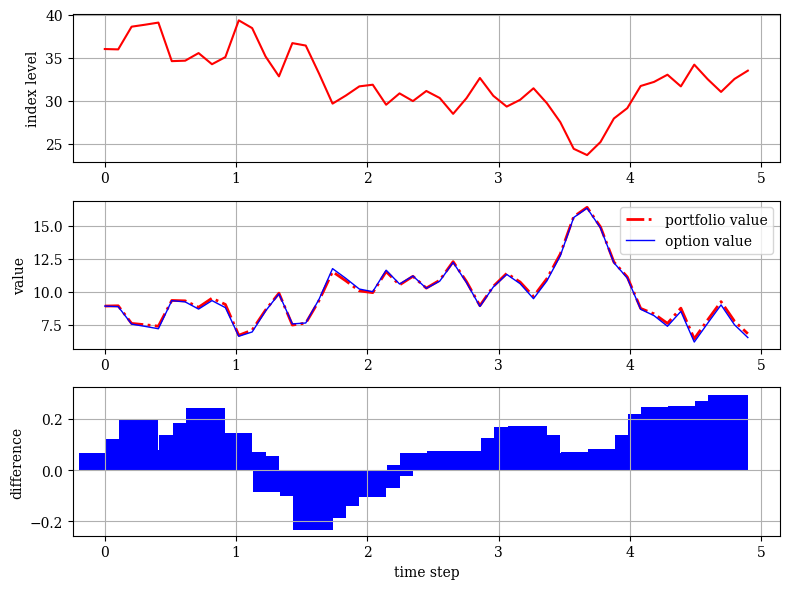

In [280]:
tl = time_grid
plt.figure(figsize=(8, 6))
plt.subplot(311)
plt.grid(True)
plt.plot(tl, s_t[:-2], 'r')
plt.ylabel('index level')
plt.subplot(312)
plt.grid(True)
plt.plot(tl, portfolio, 'r-.', label='portfolio value', lw=2)
plt.plot(tl, v, 'b', label='option value', lw=1)
plt.ylabel('value')
plt.legend(loc=0)
ax = plt.axis()
plt.subplot(313)
plt.grid(True)
wi = 0.3
diffs = portfolio - v
plt.bar(tl - wi / 2, diffs, color='b', width=wi)
plt.ylabel('difference')
plt.xlabel('time step')
plt.axis([ax[0], ax[1], min(diffs) * 1.1, max(diffs) * 1.1])
plt.tight_layout()